<a href="https://colab.research.google.com/github/yumeniown/Software-Engineering-IT-Leaders-of-the-Future/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D0%B8_%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%BA%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Деревья решений

Ранее мы рассмотрели основы бинарной классификации. Но что делать, когда классов, на которые необходимо разделить данные, больше 2? Например, классификация автомобилей по различным маркам или определение национальности по фотографии и т. д.

В таком случае используется очень простой подход, который называется «**один против всех**» (one-vs-over).

Идея этого подхода очень простая. Если у нас есть  различных классов (), давайте обучим  классификаторов, каждый из которых будет предсказывать вероятности принадлежности каждого объекта к определённому классу.

> Например, у нас есть три класса, обозначенные как 0, 1 и 2. Тогда мы обучаем три классификатора: первый из них учится отличать класс 0 от классов 1 и 2, второй — класс 1 от классов 0 и 2, а третий — класс 2 от классов 1 и 0. Таким образом, класс, на который «заточен» классификатор, мы обозначаем как 1, а остальные классы — как 0.

Когда каждая из трёх моделей сделает предсказание вероятностей для объекта, итоговый классификатор будет выдавать класс, который соответствует самой «уверенной» модели.

Схематично это можно представить следующим образом:

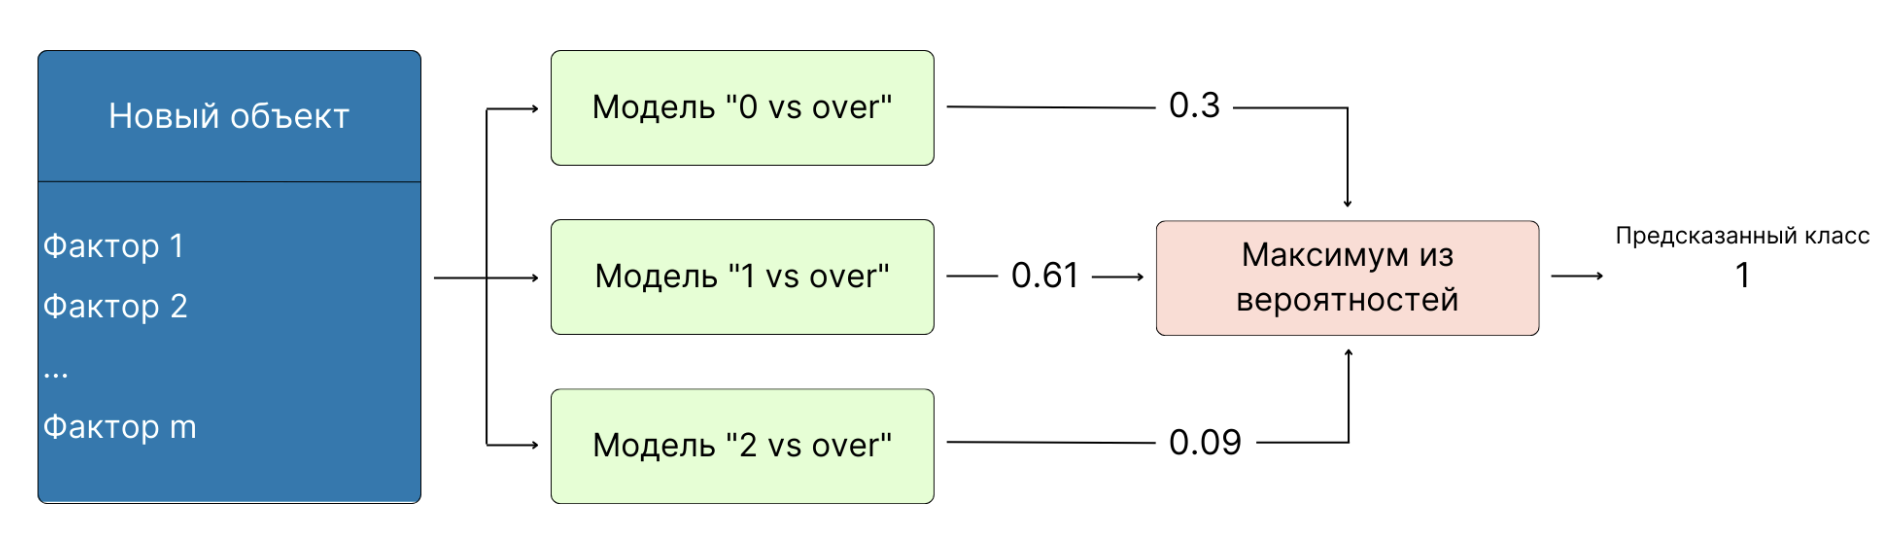

Если мы используем в качестве классификатора логистическую регрессию и количество факторов равно двум ( и ), то можно изобразить тепловую карту вероятностей принадлежности к каждому из классов в каждой точке пространства, а также разделяющие плоскости, которые образуются при пороге вероятности в 0.5.

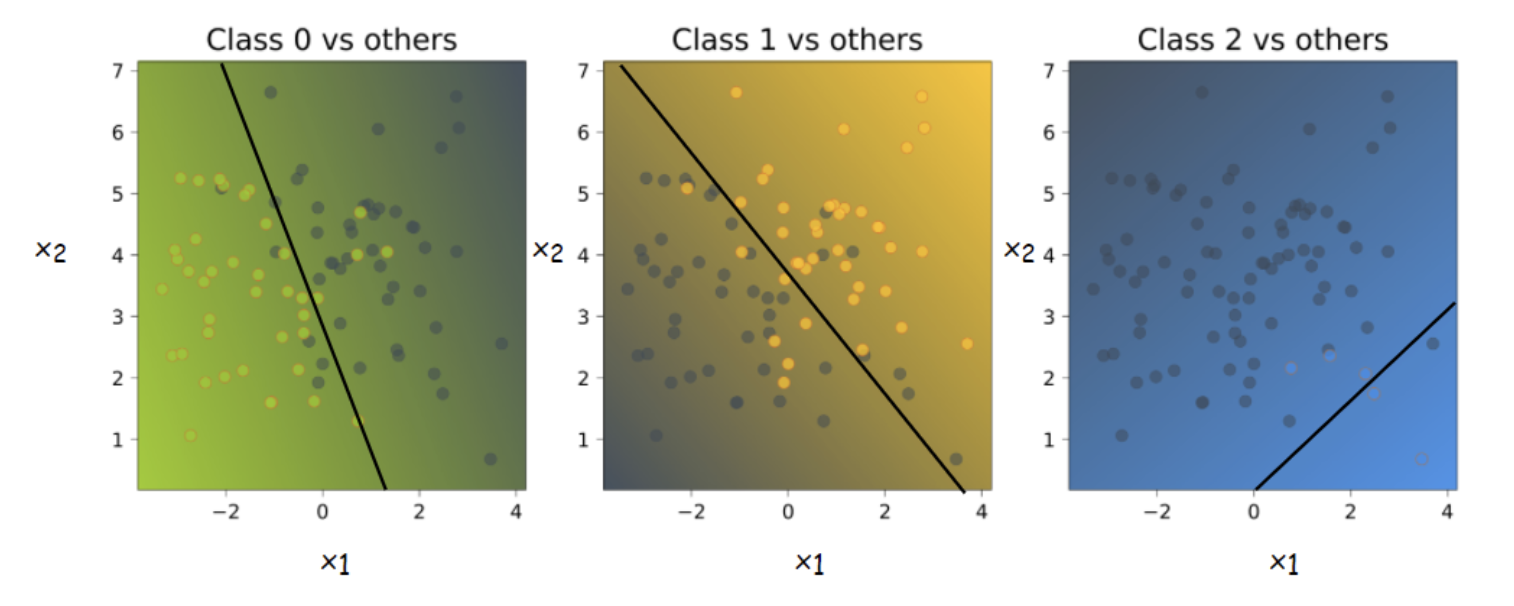

На тепловых картах каждый класс обозначен своим цветом: 0 — зелёным, 1 — жёлтым, 2 — синим. Чем ярче цвет, тем выше вероятность принадлежности к каждому к классу в этой области пространства.

В результате у нас получится три различных пространства вероятностей, что-то вроде трёх параллельных реальностей. Чтобы собрать всё это воедино, мы выбираем в каждой точке пространства максимум из вероятностей. Получим следующую картину:

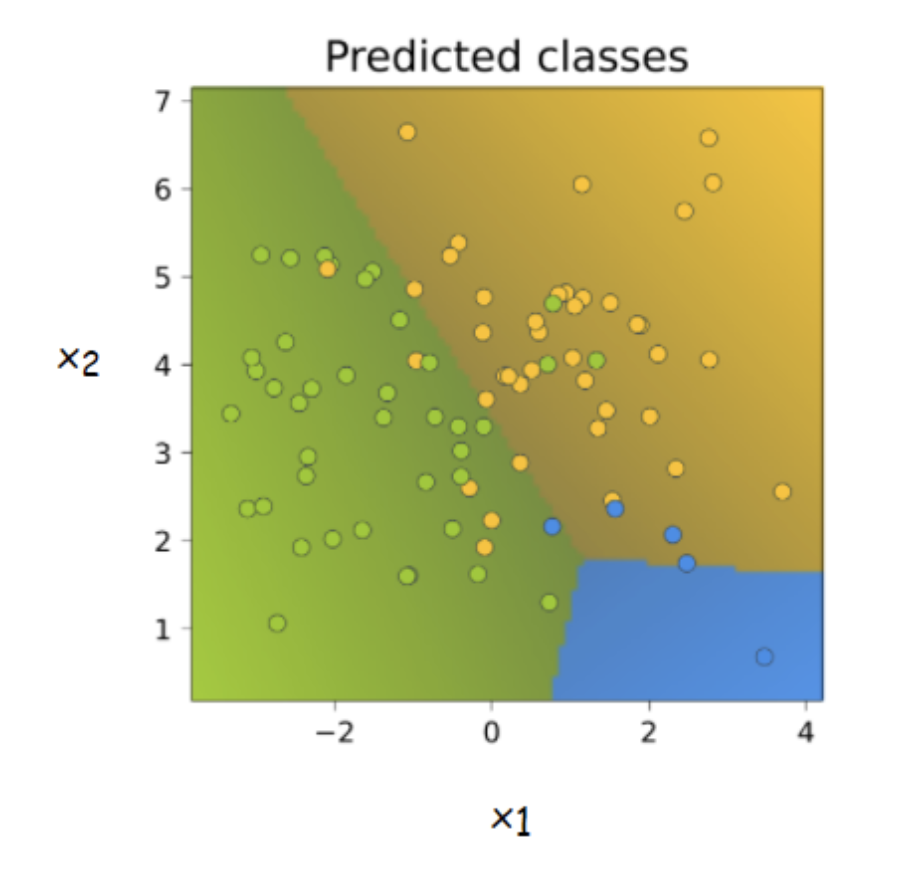

### Практика

Давайте посмотрим, как логистическая регрессия решает задачу мультиклассовой классификации.

Возьмём датасет о пингвинах из библиотеки `seaborn`:

In [ ]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики

import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')


# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
penguins_data = sns.load_dataset('penguins')
penguins_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Описание данных:

* species — класс пингвина ('Adelie', 'Chinstrap', 'Gentoo'), целевой признак;
* island — остров, на котором живёт пингвин ('Torgersen', 'Biscoe', 'Dream');
* bill_length_mm — длина клюва в миллиметрах;
* bill_depth_mm — толщина клюва в миллиметрах;
* flipper_length_mm — длина крыльев;
* body_mass_g — масса;
* sex — пол ('Male', 'Female').

Наша цель — предсказать класс пингвина.

Очевидно, что классификация является мультиклассовой, так как возможных значений три.

Для начала давайте посмотрим на пропуски в данных:

In [ ]:
penguins_data.isnull().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11


In [ ]:
penguins_data.shape

(344, 7)

Итак, в некоторых столбцах есть пропуски.

Логистическая регрессия — модель, которая не умеет работать с пропусками. Чтобы не получить ошибку, необходимо произвести предварительную предобработку. Для простоты давайте удалим все строки, содержащие пропуски в данных:

In [ ]:
penguins_data = penguins_data.dropna()

In [ ]:
penguins_data.shape

(333, 7)

Теперь, когда пропусков в данных больше нет, разделим набор данных на матрицу наблюдений `X` и столбец с ответами `y`.

In [ ]:
X = penguins_data.drop('species', axis=1)
y = penguins_data['species']
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


Данные содержат строковые категориальные столбцы — island и sex. Логистическая регрессия не умеет работать со строковыми значениями. Необходимо произвести кодирование категориальных признаков.

> Кодировать целевую переменную `y` не нужно, даже если она представлена в виде строковых значений. Это не влияет на работу модели.

In [ ]:
X_dummies = pd.get_dummies(X)
X_dummies.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,39.1,18.7,181.0,3750.0,False,False,True,False,True
1,39.5,17.4,186.0,3800.0,False,False,True,True,False
2,40.3,18.0,195.0,3250.0,False,False,True,True,False
4,36.7,19.3,193.0,3450.0,False,False,True,True,False
5,39.3,20.6,190.0,3650.0,False,False,True,False,True


Теперь данные готовы для подачи в модель.

Создаём модель логистической регрессии, значение параметра `multi_class` выставляем на `'multinomial'` (мультиклассовая классификация), `max_iter` — на 1000 (для обеспечения сходимости), `random_state=42`.

Затем обучим модель с помощью метода `fit()` и сделаем предсказание вероятностей принадлежности к каждому из классов с помощью метода `predict_proba()` и самих классов — с помощью метода `predict()`. Вероятности округлим до второго знака после запятой.

In [ ]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', #мультиклассовая классификация
    max_iter=1000, #количество итераций, выделенных на сходимость
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
log_reg.fit(X_dummies, y)
#Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_dummies), 2)
#Делаем предсказание класса
y_pred = log_reg.predict(X_dummies)

Для наглядности создадим таблицу из вероятностей для каждого класса и финального предсказания. Выберем пять случайных строк из этой таблицы с помощью метода [sample()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html):

In [ ]:
#Создаём DataFrame из вероятностей
y_pred_proba_df = pd.DataFrame(
    y_pred_proba,
    columns=['Adelie', 'Chinstrap', 'Gentoo']
)
#Создаём DataFrame из предсказанных классов
y_pred_df = pd.DataFrame(
    y_pred,
    columns=['Predicted Class']
)
#Объединяем таблицы по вертикальной оси
y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)
#Выбираем пять случайных строк
y_df.sample(5, random_state=2)

,Adelie,Chinstrap,Gentoo,Predicted Class
277,0.00,0.00,1.0,Gentoo
223,0.00,0.00,1.0,Gentoo
7,0.76,0.24,0.0,Adelie
160,0.00,1.00,0.0,Chinstrap
65,1.00,0.00,0.0,Adelie


Из таблицы можно проследить, как происходит предсказание класса пингвина на основе полученных вероятностей. Видно, что выбирается класс, вероятность принадлежности к которому максимальна.

Например, для строки под номером 7 логистическая регрессия предсказала три вероятности: 0.79 — вероятность принадлежности к классу Adelie, 0.21 — к классу Chinstrap и 0 — к классу Gentoo. На основе этих вероятностей было сделано предсказание и модель отнесла пингвина в строке 7 к классу Adelie.

Вот так и происходит мультиклассовая классификация.

Давайте посмотрим, как в таком случае будет выглядеть отчёт о метриках:

In [ ]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       146
   Chinstrap       1.00      1.00      1.00        68
      Gentoo       1.00      1.00      1.00       119

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333



Для мультиклассовой классификации к отчёту просто добавляется новая строка, соответствующая третьему классу.

Из отчёта видно, что наша модель идеально решила задачу классификации (все метрики равны 1), то есть классы оказались линейно разделимыми.

### Деревья решений

Деревья решений являются одним из наиболее понятных человеку и в то же время мощных алгоритмов принятия решений. К тому же на их основе строятся самые эффективные ансамблевые модели машинного обучения, такие как случайный лес.

Алгоритмы на основе деревьев решений могут использоваться как для решения задач классификации, так и для регрессии.  

Если коротко, решающее дерево предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил. Этот процесс в некотором смысле согласуется с естественным для человека процессом принятия решений.



Начнём сразу с примера.

Представьте, что у вас есть автомобиль, который вы решили застраховать. Вы приходите в страховую компанию, где вам дают заполнить анкету. По этой анкете сотрудник страховой компании будет принимать решение, стоит ли выдавать вам страховку.

Сотрудник в свою очередь будет руководствоваться примерно следующим регламентом:

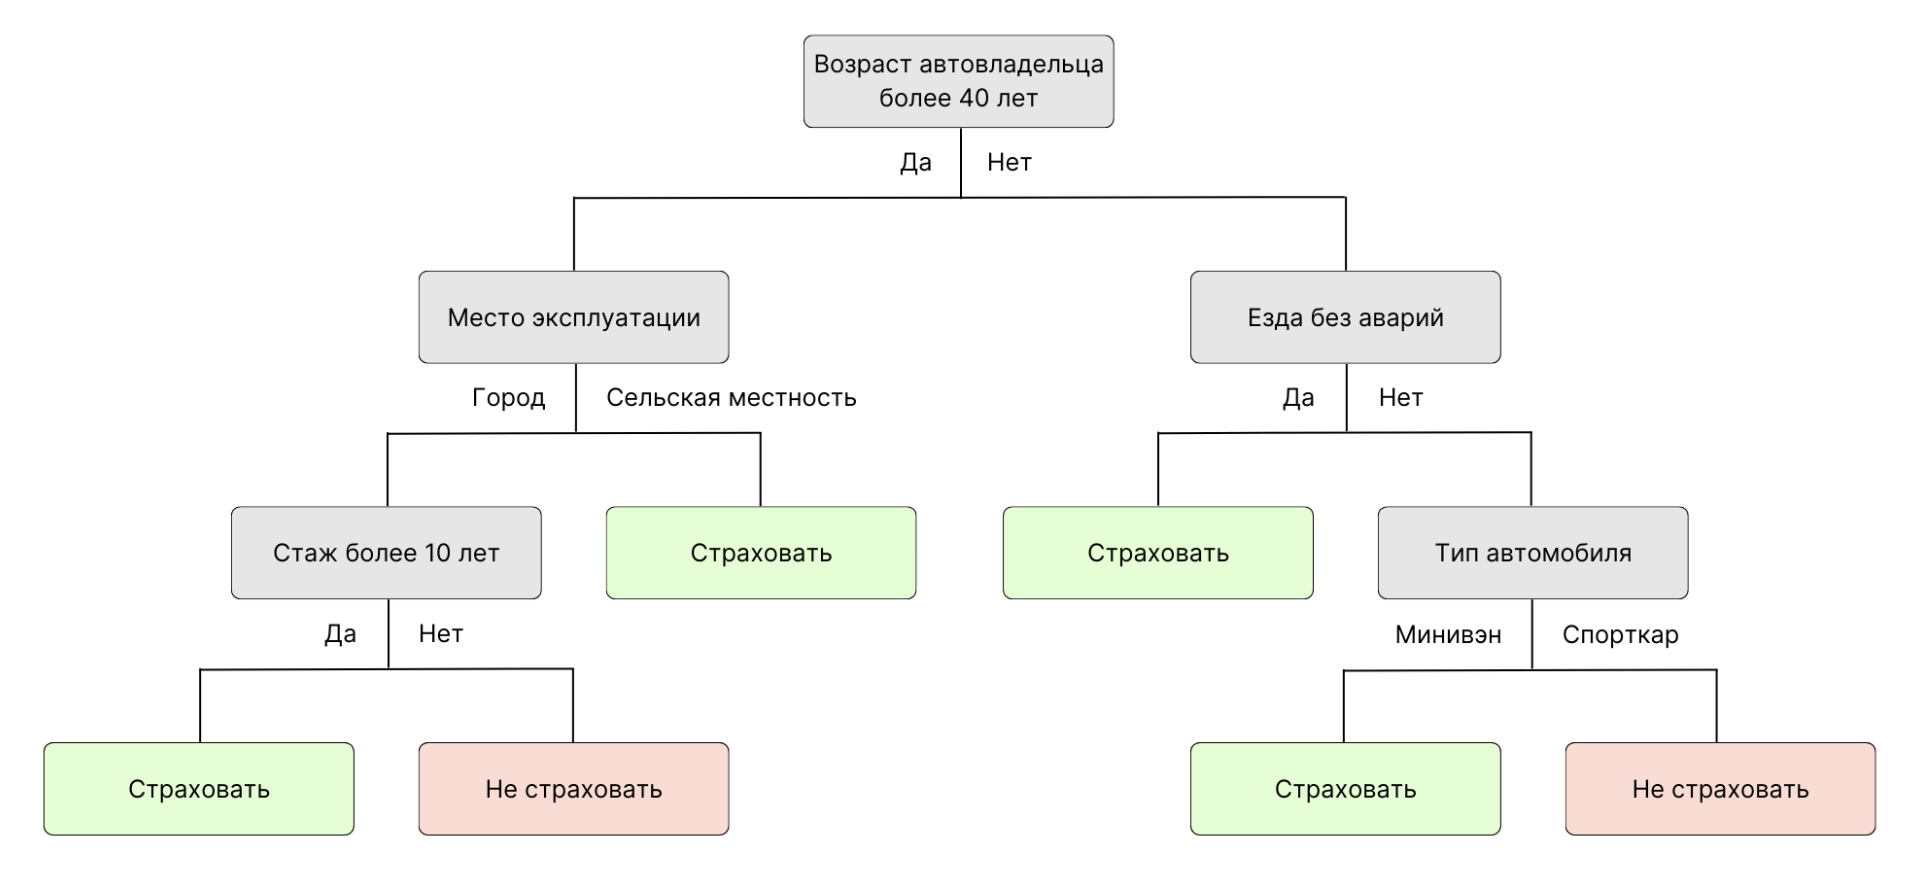

Аналогичным образом работает и алгоритм машинного обучения под названием «**дерево решений**» (Decision Tree).

Если дерево уже обучено, то есть уже сформулированы условия в прямоугольниках, то, когда в страховую компанию придёт новый автовладелец, сотруднику будет достаточно прогнать данные клиента через дерево решений и таким образом принять решение, то есть произвести классификацию.

> Вот ещё один пример дерева решений. Большинство из нас когда-нибудь играли в игру «Слова на лбу» или «Тарантинки». На лоб каждого из игроков приклеивается бумажка с написанным на ней словом. Игрок может задавать другим игрокам вопросы о загаданном ему предмете/животном/человеке и т. д. Другие игроки могут отвечать на вопросы только «Да» и «Нет». Цель — за минимальное количество вопросов догадаться, о чём идёт речь.

Логика «если …, то …» используется людьми повседневно и поэтому интуитивно понятна каждому из нас. На основании этих рассуждений можно построить мощный алгоритм машинного обучения.

Деревья решений находят своё применение во множестве прикладных задач.(Оценка кредитоспособности клиентов банка при выдаче кредитов.
 Контроль качества продукции (обнаружение дефектов в готовых товарах). Диагностика заболеваний разной сложности.


Теперь перейдём к формальной части. Нам важно уже сейчас познакомиться с терминологией деревьев решений, чтобы понять общий принцип их обучения.

Пусть у нас есть всё та же матрица наблюдений X, в которой содержатся наблюдения и характеризующие их признаки (привычный нам DataFrame), и правильные ответы y — метки классов.

Дадим определение дереву решений и его составляющим. Формально структура дерева решений — это связный ациклический граф.

* Граф — это абстрактная топологическая модель, которая состоит из вершин и соединяющих их рёбер.

* Связный граф — это граф, в котором между любой парой существует направленная связь.

* Ациклический граф — это граф, в котором отсутствуют циклы, то есть в графе не существует такого пути, по которому можно вернуться в начальную вершину.

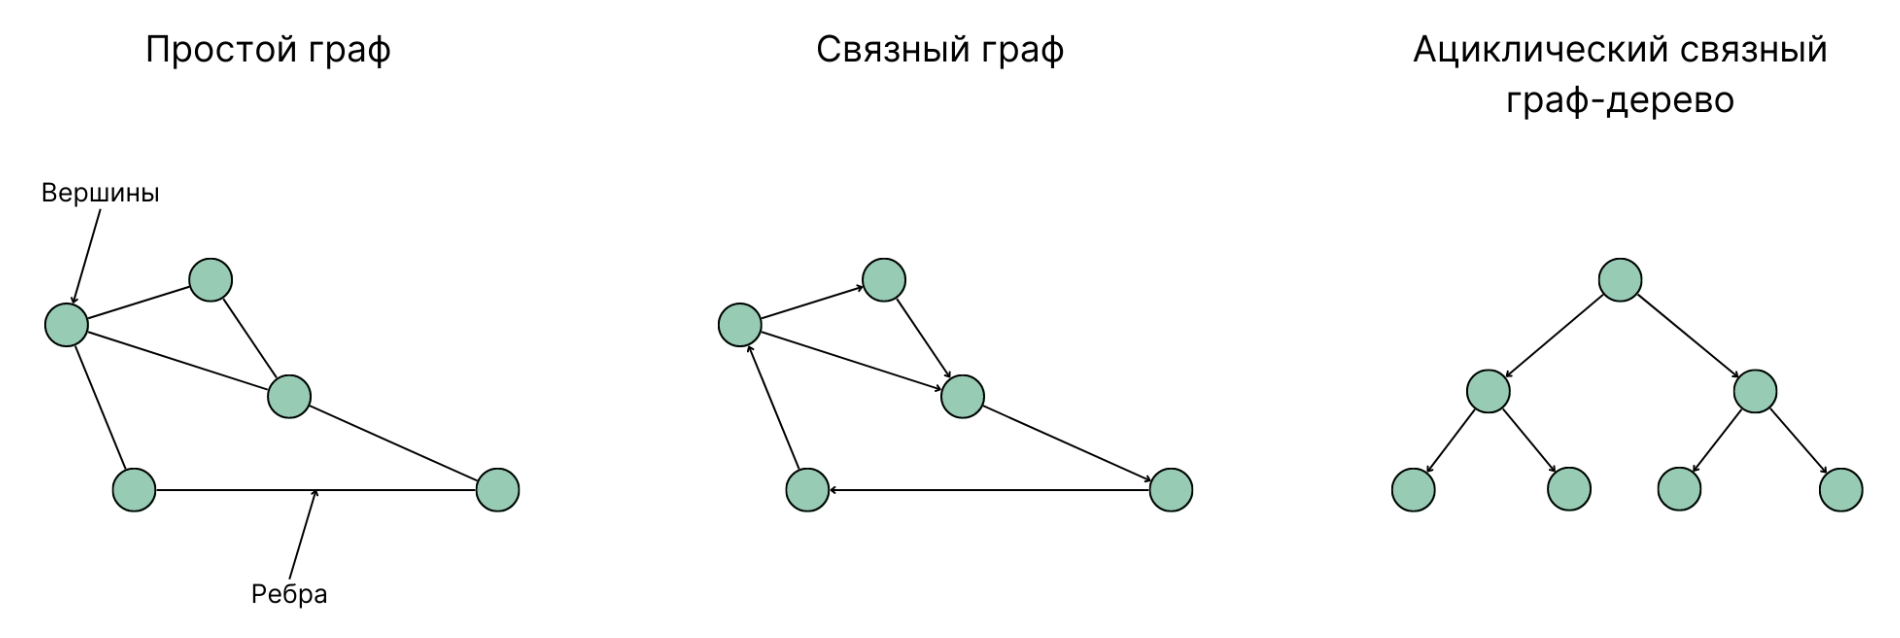

В дереве решений можно выделить три типа вершин:

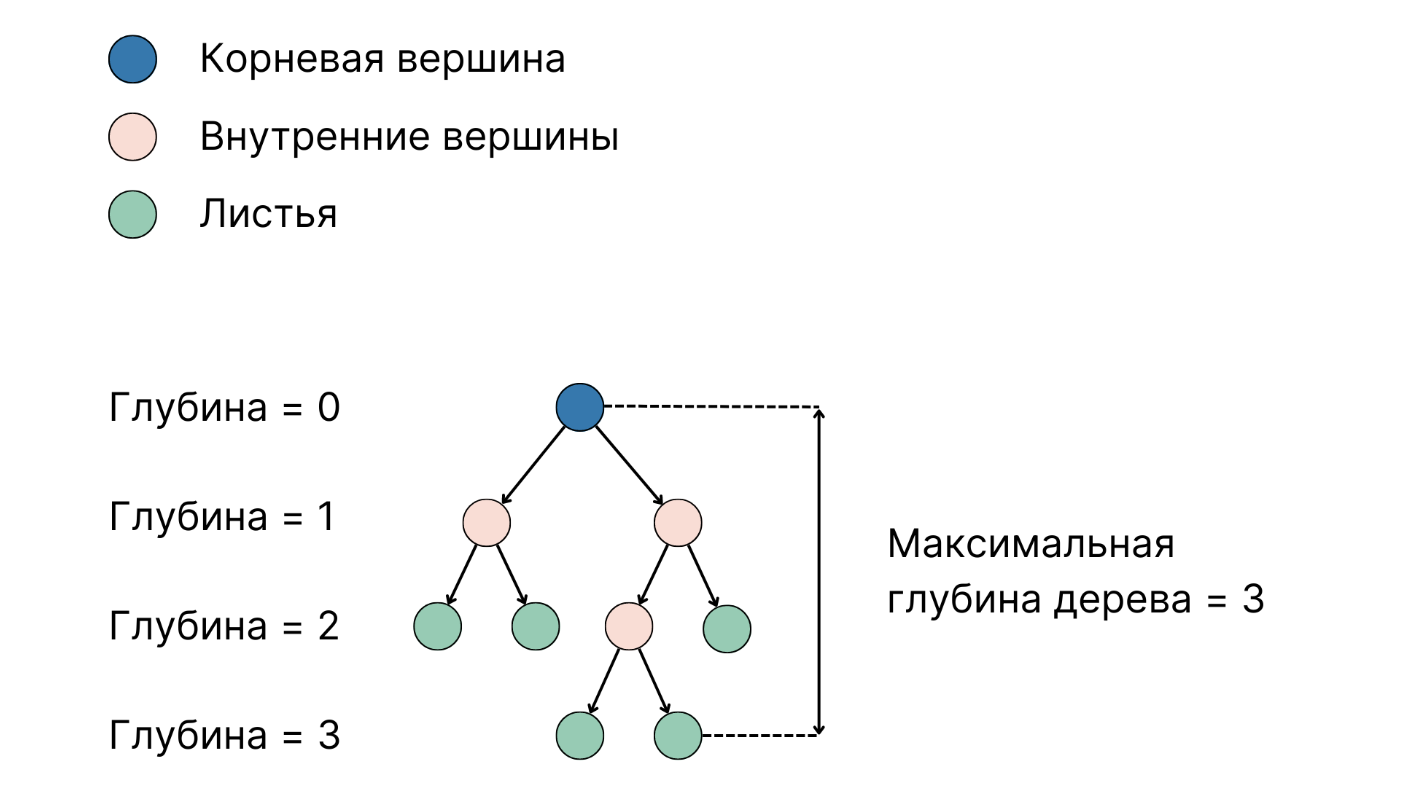

* Корневая вершина (root node) — то, откуда всё начинается. Это первый и самый главный вопрос, который дерево задаёт объекту. В примере со страхованием это был вопрос «Возраст автовладельца > 40».
* Внутренние вершины (intermediate nodes) — это дополнительные уточняющие вопросы, которые дерево задаёт объекту.
* Листья (leafs) — конечные вершины дерева. Это вершины, в которых содержится конечный «ответ» — класс объекта.

Максимально возможная длина от корня до самых дальних листьев (не включая корневую) называется **максимальной глубиной дерева**(max depth).

> Во внутренней или корневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся всё глубже по дереву. Например, «Количество кредитов  1».

Логический критерий, который находится в каждой вершине, называется **предикатом, или решающим правилом.**

На самом деле все предикаты — это просто взятие порога по значению какого-то признака. Формально это записывается следующим образом:

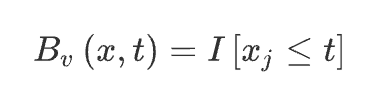

Предикат вершины дерева Bu (где u — это номер вершины) равен 1 («Да»), если признак  меньше либо равен значению , и 0 («Нет») — в противном случае. Функция I с квадратными скобками — это уже знакомая нам индикаторная функция: она равна 1, если условие внутри скобок выполняется, и 0 — в противном случае.

> В зависимости от реализации предикат может быть с условием <= или >=. В реализации sklearn используется условие <=. Но вы можете встретить другую формулировку предикатов в иных реализациях или в литературе.

Если результат предиката равен 1, то мы переходим по левой ветви дерева к следующему узлу, в противном случае — по правой ветви дерева к следующему узлу.

Каждый новый вопрос дерева решений при его обучении разбивает пространство признаков на две части: в первую часть отправляются наблюдения, для которых предикат истинен, а во вторую — для которых он ложен.

Посмотрим, как это будет выглядеть, на примере.

Вам уже знакома задача классификации про ирисы. Ирисы Фишера — это задача, на которой Рональд Фишер ещё в 1936 году (почти 100 лет назад!) продемонстрировал работу алгоритма, разделяющего ирисы на сорта в зависимости от параметров долей околоцветника.

Пусть у нас есть следующие признаки:
* длина внутренней доли околоцветника (англ. petal length);
* ширина внутренней доли околоцветника (англ. petal width).

На основании этих двух признаков требуется разделить ирисы на три сорта:
* ирис щетинистый (Iris Setosa);
* ирис виргинский (Iris virginica);
* ирис разноцветный (Iris versicolor).


Пусть мы обучили на этих данных дерево решений с максимальной глубиной 2. Оно получилось вот таким:

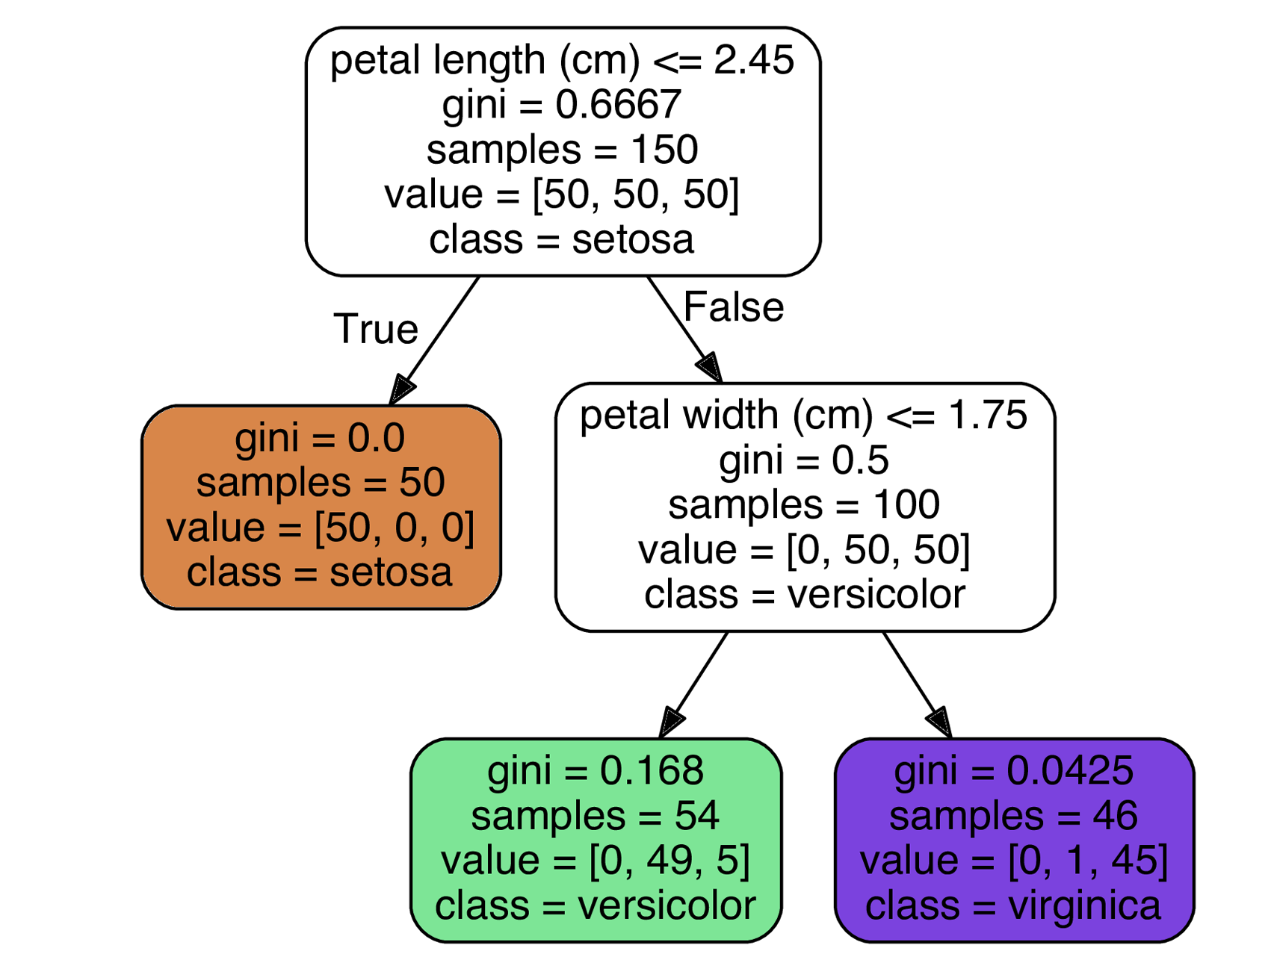

В каждом блоке указаны следующие данные:
* Предикат  — условие, по которому выборка делится на две части: на ту, для которой условие выполняется, и ту, для которой не выполняется.
* gini — критерий информативности Джини, о котором мы поговорим чуть позже.
* samples — количество объектов, которые мы проверяем на данном шаге.
* value — распределение по классам для объектов, которые мы проверяем на данном шаге: например value=[0, 50, 50] означает, что на текущем этапе разделения в выборке находится 0 объектов класса setosa и по 50 объектов классов versicolor и virginica.
* class — класс, который мы присваиваем, если завершим выполнение алгоритма на данном шаге.

#### Вопросы


1. Что представляет собой структура дерева решений?
2. Как называется записанное в вершине дерева условие, которое делит выборку, пришедшую в вершину, на две части?

#### Ответ

1. Ациклический связный граф
2. Предикат

#### Процесс построения дерева

Существует множество стратегий построения деревьев решений. Мы рассмотрим стратегию, реализованную в библиотеке sklearn, — алгоритм CART (Classification and Regression Tree), который предназначен для построения бинарных деревьев решений (деревьев, у которых каждая вершина связана с двумя другими вершинами нижнего уровня). Данный алгоритм, как следует из его названия, предназначен для решения задач классификации и регрессии.

Построение дерева решений можно описать рекурсией. Каждая вершина дерева порождает две других вершины, а они в свою очередь порождают новые вершины, и так происходит до тех пор, пока не выполнится некоторый критерий остановки, например в вершине не останутся только наблюдения определённого класса.

> Пусть у нас есть матрица наблюдений X и столбец с ответами — метками классов y. На основе примеров и ответов мы хотим построить дерево решений, которое будет производить классификацию.

Итак, псевдокод рекурсивной функции для построения решающего дерева будет выглядеть следующим образом (запускать код не нужно, так как он является абстрактным):

In [ ]:
def build_decision_tree(X, y):
    node = Node()
    if stopping_criterion(X, y) is True:
        node = create_leaf_with_prediction(y)
	    return node
    else:
        X_left, y_left, X_right, y_right = best_split(X, y)
        node.left = build_decision_tree(X_left, y_left)
        node.right = build_decision_tree(X_right, y_right)

1. Создать новую вершину node. На первой итерации это будет корневая вершина. На последующих это будут внутренние вершины.

2. Проверить некоторый критерий остановки stop_criterion().
    * Например, критерием остановки может быть следующее условие: все объекты, которые попали в вершину, — это объекты одного и того же класса.

    * Или достигнута максимальная глубина дерева (max_depth), например 5. Это значит, что дерево не будет продолжать делиться, если глубина уже равна 5.

    * Другой критерий: число наблюдений в листе (в sklearn этот параметр обозначен как min_samples_leaf) меньше заданного, например 7. Это значит, что при выполнении такого условия дерево продолжит делиться в том случае, если решающее правило выполняется как минимум для 7 наблюдений.

3. Если условие остановки выполняется:

    * Проверить, какой класс преобладает в текущей вершине. Превратить текущую вершину дерева в лист, где всем наблюдениям, которые попали в эту вершину, присвоить метку преобладающего класса.

    * Прекратить построение дерева, вернув из алгоритма полученный лист.

4. Если условие остановки не выполняется:

    * Среди всех возможных предикатов  найти такой, который обеспечивает разбиение выборки наилучшим образом.

    * То есть нужно найти такой признак  и пороговое значение , при которых достигается максимум некоторой информативности (существуют разные меры информативности, о них поговорим ниже). Назовём эту часть алгоритма некоторой абстрактной функцией best_split().

    > Например, в нашем примере с ирисами это был предикат Petal.Length <= 2.45. Он обеспечил наилучшее разделение пространства на две части.

    * В результате разбиения будут созданы два набора данных:

        * X_left, y_left (левый), для которого выполняется условие ;
        * X_right, y_right (правый), для которого условие не выполняется.

Создаются две новые вершины: левая и правая, в каждую из которых отправляется соответствующий набор данных.

То есть происходит рекурсивный вызов функции build_decision_tree(), и для каждой новой вершины алгоритм повторяется вновь с новым набором данных.


Центральный момент в построении дерева решений по обучающему набору данных — найти такой предикат , который обеспечит наилучшее разбиение выборки на классы.

> Как дерево определяет, какой вопрос нужно задать в каждой из вершин?

Например, в задаче кредитного скоринга мы можем задавать множество различных вопросов в разной последовательности. Предикаты B0 в первой вершине могут быть различными:

* возраст заёмщика <= 25 лет,
* возраст заёмщика <= 40 лет,
* размер кредита <= 1000 $,
* наличие детей <= 0.5 (если наличие детей — бинарный категориальный признак: 1 — есть дети, 0 — нет детей),
* и так далее.

Признак и его пороговое значение  в каждой из вершин и есть внутренние параметры дерева решений, которые мы пытаемся отыскать. Это аналог коэффициентов уравнения линейной и логистической регрессий.

#### Поиск параметров

Обратите внимание, что внутренние параметры дерева решений кардинально отличаются от линейных моделей.

В линейных моделях мы пытались найти такие коэффициенты в уравнениях, при которых наблюдался минимум функции потерь.

В деревьях же мы пытаемся выбрать такие признаки xj и t их пороговые значения , при которых произойдёт разделение набора на две части по какому-то критерию наилучшим образом. В нашем псевдокоде этот процесс организован в виде функции best_split().

> Важно понимать, что дерево решений — это топологический алгоритм, а не аналитический, то есть структуру дерева не получится описать в виде формулы, как те же линейные модели. Поэтому про стандартные методы оптимизации, такие как градиентный спуск или тем более метод наименьших квадратов, можно забыть.

Чтобы интуитивно понять, как организуется поиск параметров, вспомним про игру «Слова на лбу».

Пусть один человек загадывает знаменитость, а второй пытается отгадать, задавая только вопросы, на которые можно ответить «Да» или «Нет» (опустим варианты «не знаю» и «не могу сказать»).

Какой вопрос отгадывающий задаст первым делом? Конечно, такой, который лучше всего уменьшит количество оставшихся вариантов.

> К примеру, вопрос «Это Анджелина Джоли?» в случае отрицательного ответа оставит более 7.5 миллиардов вариантов для дальнейшего перебора (строго говоря, поменьше, ведь не каждый человек — знаменитость, но всё равно немало), а вот вопрос «Это женщина?» отсечёт уже около половины знаменитостей.

То есть, признак пол намного лучше разделяет выборку людей, чем признак это Анджелина Джоли, национальность — испанец или любит футбол.

Интуитивно это соответствует уменьшению некоторой неопределённости, или, иначе говоря, повышению прироста информативности.

В случае «угадайки» знаменитостей критериев отбора может быть бесчисленное количество. Но когда мы работаем с набором данных, у нас ограниченное количество признаков и для них есть ограниченное количество порогов. Тогда мы можем полным перебором найти такую комбинацию j и t, которая обеспечит наилучшее уменьшение неопределённости.

> Неопределённость можно измерять различными способами, в деревьях решений для этого используются энтропия Шеннона и критерий Джини.

#### Практика

In [ ]:
diabetes_data = pd.read_csv('drive/MyDrive/diabetes_cleaned.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


Ранее мы уже выбрали два признака, наиболее коррелирующих с целевой переменной: Glucose и BMI. Давайте вспомним, как выглядит диаграмма рассеяния, разделённая по цвету целевой переменной — признаком наличия диабета (Outcome):

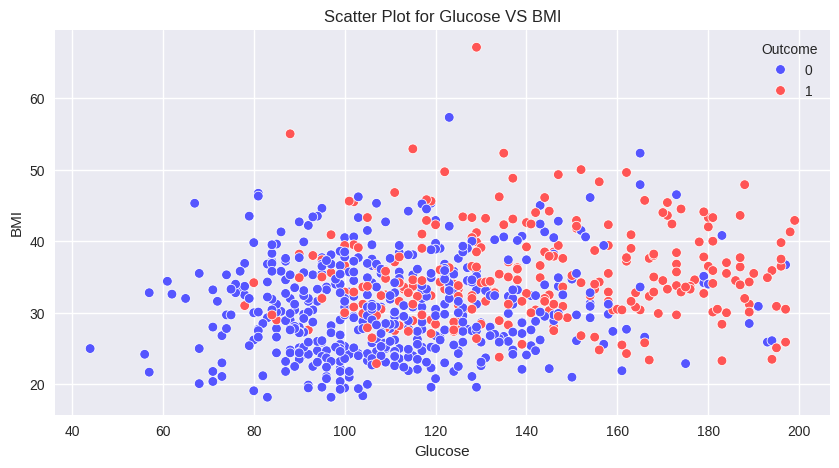

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графику
ax.set_title('Scatter Plot for Glucose VS BMI');

Создадим матрицу наблюдений `X` из признаков Glucose и BMI и столбец с правильными ответами `y` из признака Outcome:

In [ ]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

Будем решать задачу классификации пациентов с помощью дерева решений.

Модель дерева решений, его модификаций, а также функции для работы с деревьями находятся в модуле `tree` библиотеки sklearn.

In [ ]:
from sklearn import tree #модели деревьев решения

Модель дерева решений для задачи классификации реализована в классе `DecisionTreeClassifier`. Этот класс реализует обучение по алгоритму CART.

Основные параметры `DecisionTreeClassifier`:

* `criterion` — критерий информативности (`'gini'` — критерий Джини и `'entropy'` — энтропия Шеннона).
* `max_depth` — максимальная глубина дерева (по умолчанию — `None`, глубина дерева не ограничена).
* `max_features` — максимальное число признаков, по которым ищется лучшее разбиение в дереве (по умолчанию — `None`, то есть обучение производится на всех признаках). Нужно потому, что при большом количестве признаков будет «дорого» искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков.
* `min_samples_leaf` — минимальное число объектов в листе (по умолчанию — 1). У этого параметра есть понятная интерпретация: если он равен 5, то дерево будет порождать только те решающие правила, которые верны как минимум для пяти объектов.
* `random_state` — параметр, отвечающий за генерацию случайных чисел.

Давайте обучим дерево решений с критерием информативности `criterion='entropy'` (энтропия Шеннона), максимальной глубиной `max_depth=3` и параметром `random_state=42`.

За обучение, как всегда, отвечает метод `fit()`. Данный метод реализует построение дерева решений по алгоритму CART, который мы рассматривали выше (алгоритм немного оптимизирован разработчиками `sklearn`, но смысл ровно тот же).

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

Итак, мы обучили дерево решений. Обученное дерево можно визуализировать в виде графа, чтобы посмотреть, как дерево делает предсказание. Для этого есть функция [plot_tree()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) из модуля tree.

Основные параметры функции:

* `decision_tree` — объект обученного дерева решений,
* `feature_names` — названия факторов,
* `class_names` — названия классов,
* `filled` — добавлять ли расцветку вершин графа.

Вызовем эту функцию:

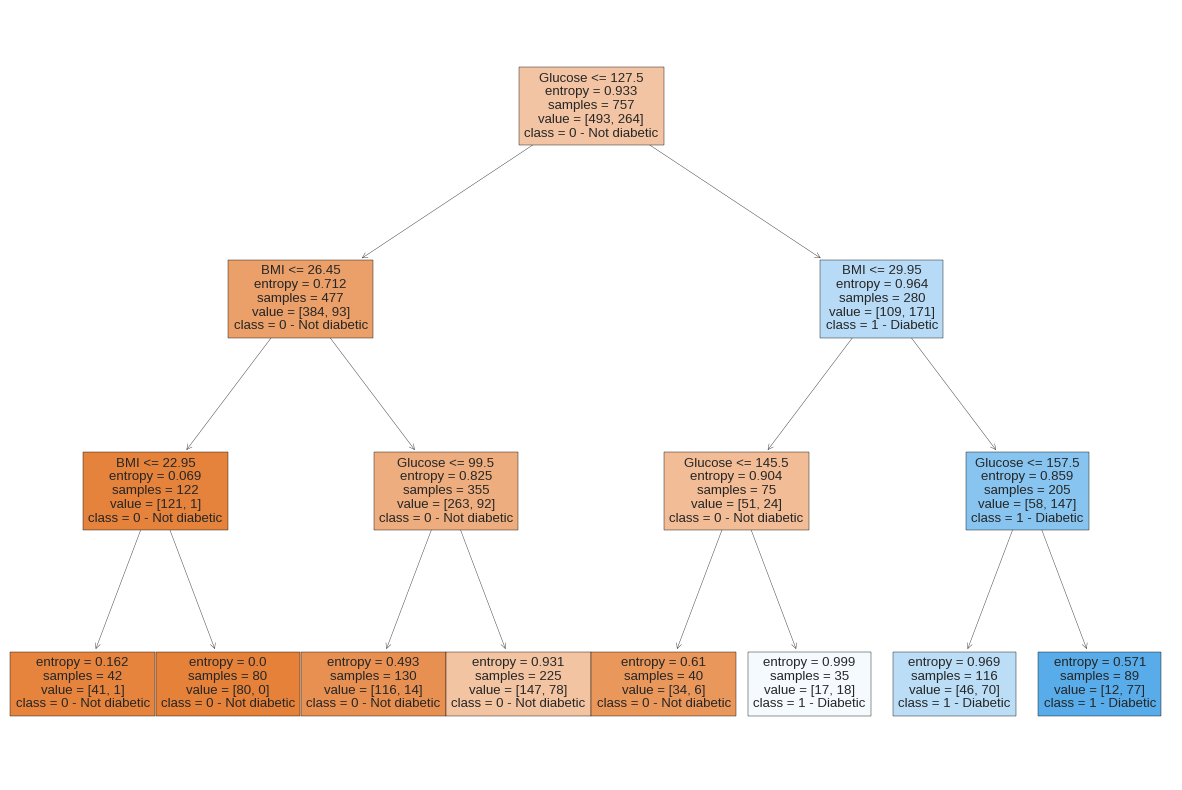

In [ ]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree_graph = tree.plot_tree(
    dt_clf_2d, #объект обученного дерева
    feature_names=X.columns, #названия факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #названия классов
    filled=True, #расцветка графа
);

В каждой из вершин записана следующая информация:

* предикат, по которому происходит разбиение;
* entropy — значение энтропии в текущей выборке;
* samples — количество объектов;
* values — количество объектов каждого из классов;
* class — преобладающий класс, на основе которого будет сделано предсказание.

**Как такое дерево будет делать предсказание?**

Например, появился новый пациент с концентрацией глюкозы 180 мг/100 мл и индексом массы тела 51 $кг/м^2$. Мы хотим вычислить вероятность наличия/отсутствия диабета у такого пациента.

«Прогоняем» характеристики пациента через предикаты в вершинах графа. Если предикат равен `True`, то идём по левому ребру вглубь графа, а если `False` — по правому.

1. `[Glucose <= 127.5] = False`. Переходим в правую вершину.

2. `[BMI <= 29.49] = False`. Переходим в правую вершину.

3. `[Glucose <= 157.5] = False`. Переходим в правую вершину.

4. Мы добрались до листовой вершины, которая соответствует объектам класса 1 — Diabetic. Значит, дерево определит данного пациента как больного диабетом.

    Вероятность наличия диабета в данном листе равна $77/(12+77)=0.865$.

    Вероятность отсутствия диабета: $12/(12+77)=0.135$.

Описанные выше операции дерево производит автоматически с помощью функции `predict()`, предназначенной для предсказания класса объекта.

In [ ]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = dt_clf_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


И `predict_proba()` — для предсказания вероятности принадлежности к каждому из классов:

In [ ]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

Predicted probabilities: [[0.135 0.865]]


Давайте посмотрим, как будет выглядеть разделяющая поверхность дерева решений для двух признаков.

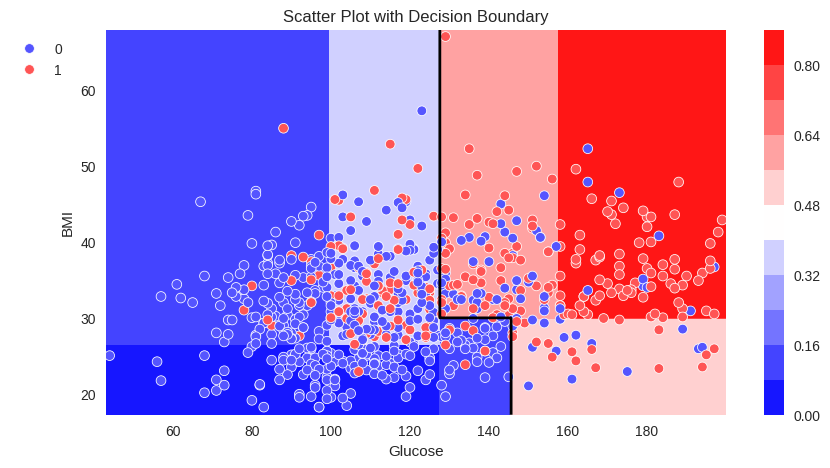

In [ ]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199,
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку.
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 10, cmap='bwr')
    #Рисуем разделяющую плоскость — линия, где вероятность равна 0.5.
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

plot_probabilities_2d(X, y, dt_clf_2d)

Как и ожидалось, дерево решений разделило пространство на множество прямоугольных частей, каждая из которых соответствует определённому листу дерева.

Количество этих областей равно количеству листьев — 8.

> Так как вероятности в двух областях практически совпадают, на тепловой карте разница незаметна, области сливаются в одну и мы видим семь областей.

Чёрным обозначена граница, где вероятность наличия диабета равна 0.5. Точки, находящиеся правее этой разделяющей границы, относятся деревом к классу 1, а находящиеся левее, — к классу 0.

Можно рассчитать полученные метрики качества. Для этого предскажем наличие диабета для всех пациентов из матрицы наблюдений `X`, а затем рассчитаем метрики классификации с помощью функции `classification_report()` из библиотеки `sklearn`:

In [ ]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_2d.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       493
           1       0.69      0.62      0.65       264

    accuracy                           0.77       757
   macro avg       0.75      0.74      0.74       757
weighted avg       0.77      0.77      0.77       757



> Если вы сравните данный отчёт с полученным ранее для логистической регрессии, обученной на двух признаках, то увидите, что даже с небольшой глубиной 3 дерево решений решает задачу классификации лучше, чем логистическая регрессия.

Давайте построим дерево решений без ограничения его максимальной глубины. Для этого нам просто не нужно задавать параметр `max_depth`:

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART без ограничения его глубины
dt_clf_bad.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_bad.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       493
           1       1.00      0.97      0.98       264

    accuracy                           0.99       757
   macro avg       0.99      0.98      0.99       757
weighted avg       0.99      0.99      0.99       757



Как выросли метрики! Задача, над которой бьются медики всего мира, решается простейшим алгоритмом машинного обучения с потрясающей точностью! Причём для диагностики нам достаточно всего двух признаков — уровня глюкозы и индекса массы тела.

> Не кажется ли вам, что здесь что-то не так?

Давайте визуализируем граф:

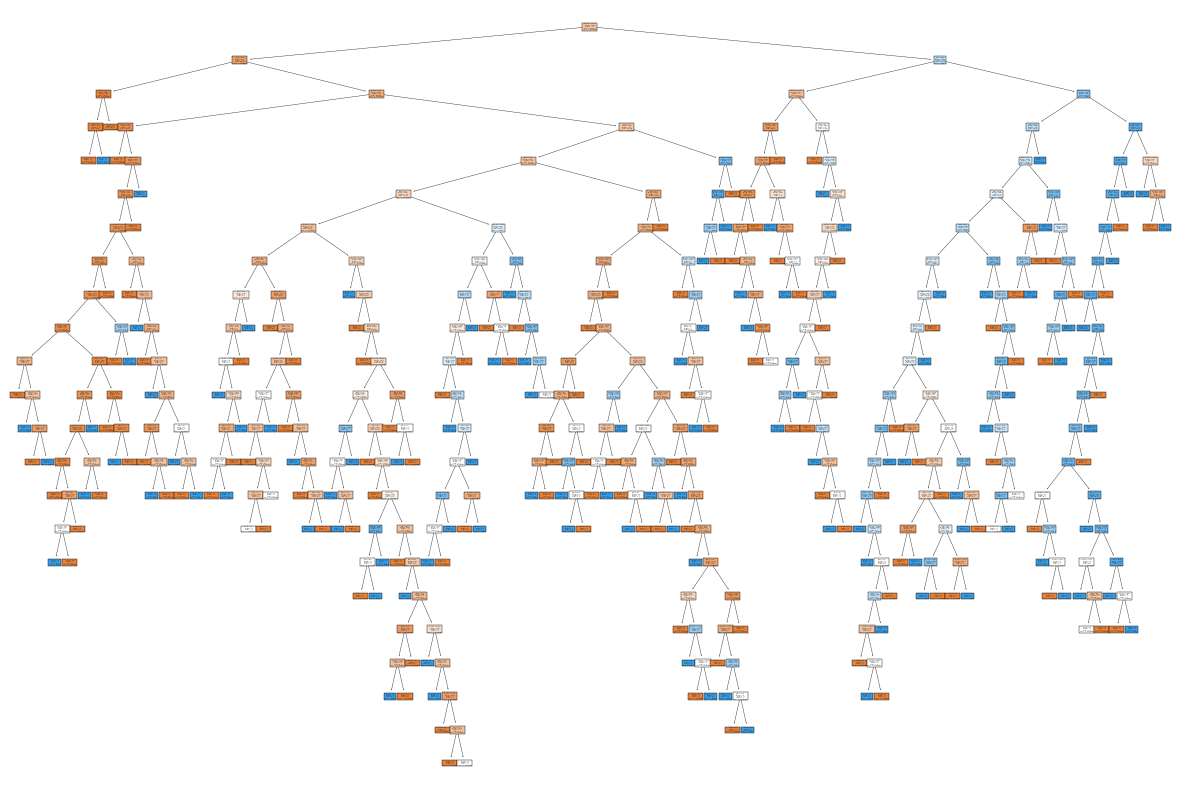

In [ ]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree_graph = tree.plot_tree(
    dt_clf_bad, #объект обученного дерева
    feature_names=X.columns, #названия факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #названия классов
    filled=True, #расцветка графа
);

Абсолютный хаос. Дерево задаёт огромное количество вопросов для того, чтобы предсказать правильный диагноз для каждого пациента из набора данных.

In [ ]:
dt_clf_bad.get_depth()

22

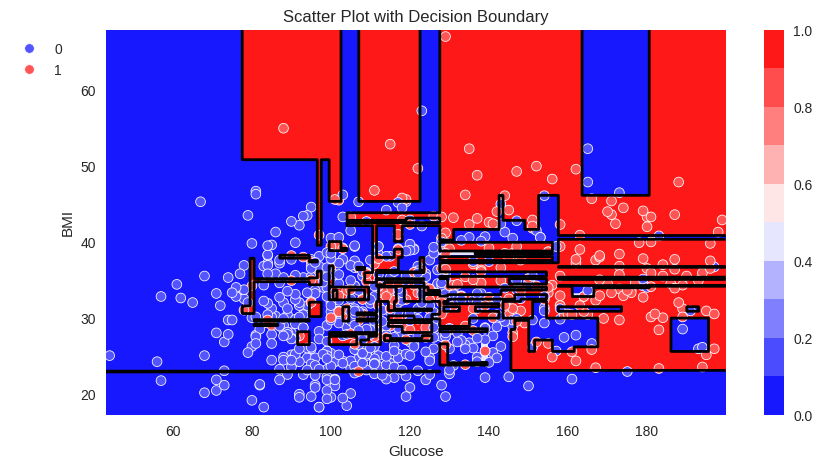

In [ ]:
plot_probabilities_2d(X, y, dt_clf_bad)

Перед нами типичная картина переобучения дерева решений. Дерево решений разделило пространство на огромное количество отдельных частей, чтобы обозначить все точки из обучающего набора данных правильным классом (уменьшить энтропию до нуля).

Конечно же, такая модель не имеет никакой обобщающей способности и никому не нужна.



> Всегда используйте регуляризацию деревьев — ограничивайте их максимальную глубину (`max_depth`) и минимальное число объектов в листе (`min_samples_leaf`).

> К тому же всегда стоит иметь под рукой не только обучающий, но и тестовый набор данных, чтобы оценить переобучение.


Давайте попробуем обучить дерево решений на всех признаках. Принцип остаётся тем же, меняется только матрица наблюдений `X`:

In [ ]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X, y)

#Делаем предсказание класса
y_pred = dt_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       493
           1       0.84      0.69      0.76       264

    accuracy                           0.85       757
   macro avg       0.84      0.81      0.82       757
weighted avg       0.84      0.85      0.84       757



Метрики значительно улучшились по сравнению с обучением на двух признаках.

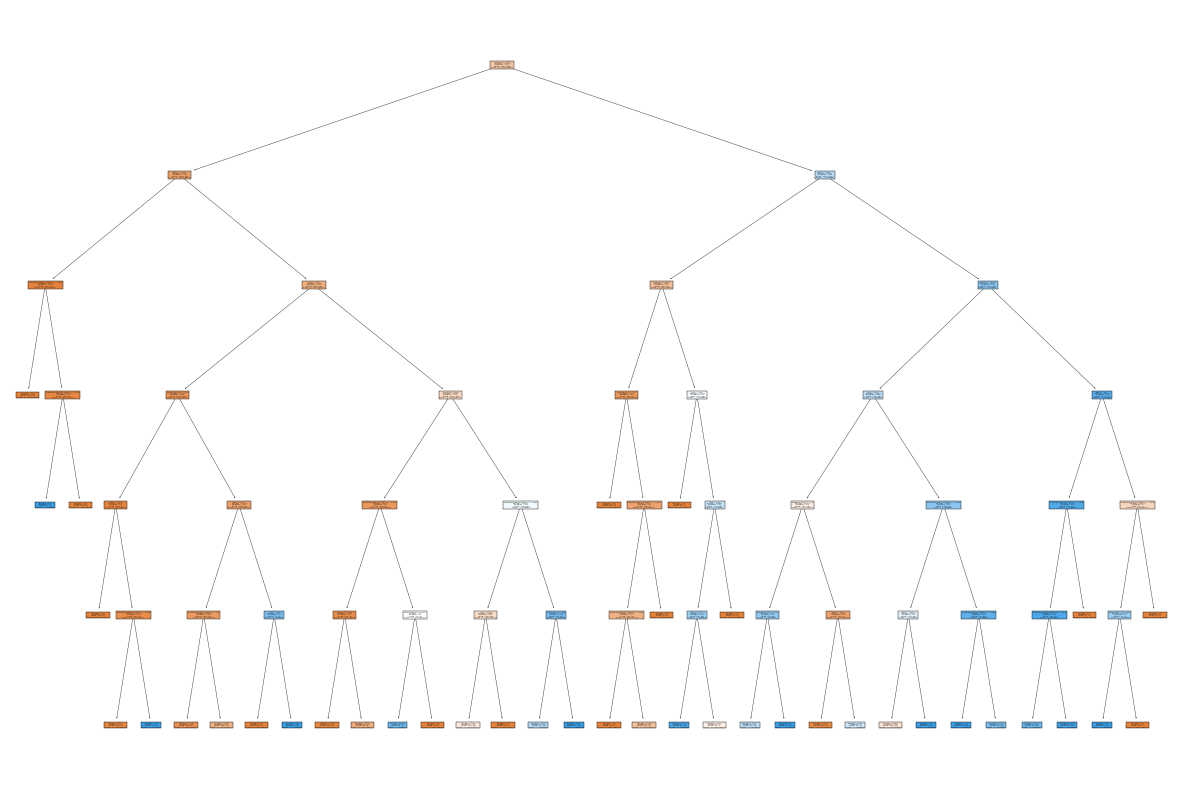

In [ ]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree_graph = tree.plot_tree(
    dt_clf_full, #объект обученного дерева
    feature_names=X.columns, #названия факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #названия классов
    filled=True, #расцветка графа
);

Плюсы деревьев:
* Дерево решений не требует нормализации/стандартизации данных.
* Наличие пропусков не оказывает существенного влияния на построение дерева.
* За счёт своей простоты модель деревьев решений интуитивно понятна и легко объяснима даже людям, не разбирающимся в методе.
* Приятный побочный эффект построения дерева решений — получение значимости признаков. Однако коэффициенты значимости целиком и полностью зависят от сложности дерева.

Минусы:
* В силу дискретной топологической структуры дерево не дифференцируется по параметрам: стандартные алгоритмы поиска параметров, такие как градиентный спуск, не работают. Приходится использовать полный перебор.
* Так как метод является жадным, он долго обучается из-за полного перебора. Требует затрат больших вычислительных мощностей (по сравнению с другими алгоритмами). Особенно это ощутимо при большом количестве признаков на глубоких деревьях.
* Очень сильная склонность к переобучению.
* Небольшое изменение в данных может заметно повлиять на структуру дерева.
* При работе с непрерывными числовыми признаками дерево делит их на категории и теряет информацию. Лучше всего дерево работает, если перевести числовые признаки в категориальные.